In [1]:
from __future__ import division
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, average_precision_score, matthews_corrcoef, make_scorer

from sklearn.feature_selection import SelectKBest,chi2, f_classif, mutual_info_classif, VarianceThreshold

### 1. Download the dataset(s) for your project. If a train set and a test set are not already available, randomly split the dataset into a train and a test set using stratified sampling so that 80% of the samples go to train set and 20% to test set.

Data was retrieved from: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

### 2. Randomly split your train set into a validation and a new train set (called train set 2) such that the validation set contains 1/5 of the samples in original train set and the train set 2 contains the remaining. Use stratified sampling to assign features to train set 2 and validation set. This should ensure that your validation set contains samples from both classes (i.e. ciliary and non-ciliary with equal proportions)

In [2]:
train_data = pd.read_csv("datatraining.csv")

y_train = train_data['Occupancy']
X_train = train_data.loc[:, train_data.columns != 'Occupancy']

X_train_two, X_validation, y_train_two, y_validation = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

test_data = pd.read_csv("datatest.csv") # My dataset has two test sets. This is test1.

y_test = test_data['Occupancy']
X_test = test_data.loc[:, test_data.columns != 'Occupancy']

test_data2 = pd.read_csv("datatest2.csv") # My dataset has two test sets. This is test1.

y_test2 = test_data2['Occupancy']
X_test2 = test_data2.loc[:, test_data2.columns != 'Occupancy']

### 3. Normalize features in your train set 2 and validation set using min-max scaling to interval [0,1]. For this purpose you can first normalize features in your train set 2 and use the same scaling coefficients to normalize validation set. Save the normalized versions as separate files. Repeat normalizing your original train set and use the same normalization coefficients to normalize the two test sets.

In [3]:
scaler = MinMaxScaler()

scaler.fit(X_train_two)
normalized_x_train_two = scaler.transform(X_train_two)
normalized_x_validation_train_two = scaler.transform(X_validation)

np.savetxt("normalized_x_train_two.csv", normalized_x_train_two, delimiter=",")
np.savetxt("normalized_x_validation.csv", normalized_x_validation_train_two, delimiter=",")

scaler.fit(X_train)
normalized_x_train = scaler.transform(X_train)
normalized_x_test = scaler.transform(X_test)
normalized_x_test2 = scaler.transform(X_test2)
normalized_x_validation_with_orig = scaler.transform(X_validation)

### 4. Perform a 10-fold cross-validation experiment for the random forest classifier on normalized and unnormalized versions of train set 2. You can set the number of trees to 100. Do you get better accuracy when you perform data normalization?

In [4]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
kfold = StratifiedKFold(n_splits=10, random_state=42)

unnormalized_accuracy = cross_val_score(clf, X_train_two, y_train_two, cv=kfold).mean()
normalized_accuracy = cross_val_score(clf, normalized_x_train_two, y_train_two, cv=kfold).mean()

if unnormalized_accuracy >= normalized_accuracy:
    print("No, I did not. Unnormalized Accuracy: {}, Normalized Accuracy: {}"
          .format(unnormalized_accuracy,normalized_accuracy))
else:
    print("Yes, I did. Unnormalized Accuracy: {}, Normalized Accuracy: {}"
          .format(unnormalized_accuracy,normalized_accuracy))

Yes, I did. Unnormalized Accuracy: 0.99416494608, Normalized Accuracy: 0.994471930145


### 5. Perform a 10-fold cross-validation experiment on train set 2 that corresponds to the best performing normalization strategy (i.e. normalized or unnormalized) for the following classifiers: 

Logistic regression

k-nearest neighbor (with k=1)

Naïve Bayes

Decision tree

Random forest (number of trees=100)

SVM (RBF kernel C=1.0 gamma=0.125)

Linear Discriminant Analysis (This model is used instead of RBF Network)

Adaboost (number of iterations=10)

You can use default values for other hyper-parameters of the classifiers
Report the following accuracy measures for each of these classifiers: overall
accuracy, F-measure, sensitivity, specificity, precision, area under the ROC curve,
area under the precision recall curve, MCC scores. These will be cross-validation
accuracies.

In [5]:
models = [
    ("Logistic Regression",LogisticRegression(random_state=42)),
    ("K-Nearest Neighbour",KNeighborsClassifier(n_neighbors=1)),
    ("Naive Bayes",GaussianNB()),
    ("Decision Tree",DecisionTreeClassifier(random_state=42)),
    ("Random Forest",RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Support Vector Machine",SVC(kernel="rbf", C=1,gamma=0.125, random_state=42)),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("AdaBoostClassifier",AdaBoostClassifier(n_estimators=10, random_state=42))
]

metrics = [
    ("Accuracy Score", accuracy_score),
    ("F-Measure", f1_score),
    ("Sensitivity", recall_score),
    ("Specificity", recall_score),
    ("Precision", precision_score),
    ("Area Under ROC Curve", roc_auc_score),
    ("Area Under Precision Recall Curve", average_precision_score),
    ("MCC", matthews_corrcoef)
]

def dump_metrics_with_cv(features, label, name, model):
    accuracy = 0.0
    
    for metric_name, metric in metrics:
        kfold = StratifiedKFold(n_splits=10, random_state=42)
        scorer = make_scorer(metric,pos_label=0) if metric_name == "Specificity" else make_scorer(metric)

        cv_result = cross_val_score(model,features,label.values.ravel(), cv = kfold,scoring = scorer)
        
        if metric_name == "Accuracy Score":
            accuracy = cv_result

        print("{} {}: {}".format(name, metric_name, cv_result.mean()))
    print("")
    
    return accuracy.mean()

for name,model in models:
    print("Unnormalized Results for {}:\n".format(name))
    dump_metrics_with_cv(X_train_two, y_train_two, name, model)
    
    print("\nNormalized Results for {}:\n".format(name))
    dump_metrics_with_cv(normalized_x_train_two, y_train_two, name, model)

Unnormalized Results for Logistic Regression:

Logistic Regression Accuracy Score: 0.982649389021
Logistic Regression F-Measure: 0.96063221029
Logistic Regression Sensitivity: 0.99133041393
Logistic Regression Specificity: 0.980313787062
Logistic Regression Precision: 0.932265962074
Logistic Regression Area Under ROC Curve: 0.985822100496
Logistic Regression Area Under Precision Recall Curve: 0.925995821007
Logistic Regression MCC: 0.950474980812


Normalized Results for Logistic Regression:

Logistic Regression Accuracy Score: 0.988945271712
Logistic Regression F-Measure: 0.974631060518
Logistic Regression Sensitivity: 0.997826086957
Logistic Regression Specificity: 0.986551603826
Logistic Regression Precision: 0.952632448389
Logistic Regression Area Under ROC Curve: 0.992188845391
Logistic Regression Area Under Precision Recall Curve: 0.951010106793
Logistic Regression MCC: 0.968055905242

Unnormalized Results for K-Nearest Neighbour:

K-Nearest Neighbour Accuracy Score: 0.9933985439

### 6. Use three feature selection methods to select feature subsets on train set 2 and compute accuracy measures in step 5 for all the classifiers. Repeat for normalized version of train set 2. Do you get improvement in accuracy when you perform feature selection or is it better to use all of the features? Which feature selection strategy gives the best accuracy?

In [6]:
for name, model in models:
    selectors = [
        ("VarianceThreshold", VarianceThreshold()),
        ("SelectKBest with f_classif 1", SelectKBest(f_classif,k=1)),
        ("SelectKBest with chi2 1", SelectKBest(chi2,k=1)),
        ("SelectKBest with f_classif 2", SelectKBest(f_classif,k=2)),
        ("SelectKBest with chi2 2", SelectKBest(chi2,k=2)),
        ("SelectKBest with f_classif 3", SelectKBest(f_classif,k=3)),
        ("SelectKBest with chi2 3", SelectKBest(chi2,k=3)),
        ("SelectKBest with f_classif 4", SelectKBest(f_classif,k=4)),
        ("SelectKBest with chi2 4", SelectKBest(chi2,k=4)),
        ("SelectKBest with f_classif 5", SelectKBest(f_classif,k=5)),
        ("SelectKBest with chi2 5", SelectKBest(chi2,k=5)),
        ("SelectKBest with f_classif 6", SelectKBest(f_classif,k=6)),
        ("SelectKBest with chi2 7", SelectKBest(chi2,k=6)),
        ("SelectKBest with f_classif 7", SelectKBest(f_classif,k=7)),
        ("SelectKBest with chi2 7", SelectKBest(chi2,k=7))
    ]
    
    for selector_name, selector in selectors:  
        selected_x_train_two = selector.fit_transform(X_train_two, y=y_train_two)
        normalized_selected_x_train_two  = selector.fit_transform(normalized_x_train_two, y=y_train_two)

        print("{} unnormalized results:\n".format(selector_name))
        dump_metrics_with_cv(selected_x_train_two, y_train_two, name, model)

        print("{} normalized results:\n".format(selector_name))
        dump_metrics_with_cv(normalized_selected_x_train_two, y_train_two, name, model)

print("Yes, I did get improvement when I performed feature selection.")
print("SelectKBest that uses chi2 with 4 features gave the best accuracy.")

VarianceThreshold unnormalized results:

Logistic Regression Accuracy Score: 0.982649389021
Logistic Regression F-Measure: 0.96063221029
Logistic Regression Sensitivity: 0.99133041393
Logistic Regression Specificity: 0.980313787062
Logistic Regression Precision: 0.932265962074
Logistic Regression Area Under ROC Curve: 0.985822100496
Logistic Regression Area Under Precision Recall Curve: 0.925995821007
Logistic Regression MCC: 0.950474980812

VarianceThreshold normalized results:

Logistic Regression Accuracy Score: 0.988945271712
Logistic Regression F-Measure: 0.974631060518
Logistic Regression Sensitivity: 0.997826086957
Logistic Regression Specificity: 0.986551603826
Logistic Regression Precision: 0.952632448389
Logistic Regression Area Under ROC Curve: 0.992188845391
Logistic Regression Area Under Precision Recall Curve: 0.951010106793
Logistic Regression MCC: 0.968055905242

SelectKBest with f_classif 1 unnormalized results:

Logistic Regression Accuracy Score: 0.981881103546
Logis

Logistic Regression Accuracy Score: 0.98863805205
Logistic Regression F-Measure: 0.97390423569
Logistic Regression Sensitivity: 0.996376811594
Logistic Regression Specificity: 0.986551603826
Logistic Regression Precision: 0.952569785956
Logistic Regression Area Under ROC Curve: 0.99146420771
Logistic Regression Area Under Precision Recall Curve: 0.949871018481
Logistic Regression MCC: 0.967110414133

SelectKBest with f_classif 5 normalized results:

Logistic Regression Accuracy Score: 0.988945271712
Logistic Regression F-Measure: 0.974631060518
Logistic Regression Sensitivity: 0.997826086957
Logistic Regression Specificity: 0.986551603826
Logistic Regression Precision: 0.952632448389
Logistic Regression Area Under ROC Curve: 0.992188845391
Logistic Regression Area Under Precision Recall Curve: 0.951010106793
Logistic Regression MCC: 0.968055905242

SelectKBest with chi2 5 unnormalized results:

Logistic Regression Accuracy Score: 0.968371914167
Logistic Regression F-Measure: 0.92918152

K-Nearest Neighbour F-Measure: 0.967829843397
K-Nearest Neighbour Sensitivity: 0.968183713898
K-Nearest Neighbour Specificity: 0.99122920791
K-Nearest Neighbour Precision: 0.967550011385
K-Nearest Neighbour Area Under ROC Curve: 0.979706460904
K-Nearest Neighbour Area Under Precision Recall Curve: 0.943638331349
K-Nearest Neighbour MCC: 0.959184981901

SelectKBest with f_classif 2 normalized results:

K-Nearest Neighbour Accuracy Score: 0.986642537112
K-Nearest Neighbour F-Measure: 0.968584946594
K-Nearest Neighbour Sensitivity: 0.969632989261
K-Nearest Neighbour Specificity: 0.99122920791
K-Nearest Neighbour Precision: 0.967665609231
K-Nearest Neighbour Area Under ROC Curve: 0.980431098585
K-Nearest Neighbour Area Under Precision Recall Curve: 0.944788671862
K-Nearest Neighbour MCC: 0.960154943419

SelectKBest with chi2 2 unnormalized results:

K-Nearest Neighbour Accuracy Score: 0.982958492023
K-Nearest Neighbour F-Measure: 0.960185840518
K-Nearest Neighbour Sensitivity: 0.9667448649

K-Nearest Neighbour Specificity: 0.995517706935
K-Nearest Neighbour Precision: 0.983501777729
K-Nearest Neighbour Area Under ROC Curve: 0.990530722928
K-Nearest Neighbour Area Under Precision Recall Curve: 0.972319984519
K-Nearest Neighbour MCC: 0.980319749123

SelectKBest with chi2 7 normalized results:

K-Nearest Neighbour Accuracy Score: 0.993399721214
K-Nearest Neighbour F-Measure: 0.984383043879
K-Nearest Neighbour Sensitivity: 0.98194661662
K-Nearest Neighbour Specificity: 0.996492365804
K-Nearest Neighbour Precision: 0.987018253013
K-Nearest Neighbour Area Under ROC Curve: 0.989219491212
K-Nearest Neighbour Area Under Precision Recall Curve: 0.972979612679
K-Nearest Neighbour MCC: 0.98027803497

SelectKBest with f_classif 7 unnormalized results:

K-Nearest Neighbour Accuracy Score: 0.993398543946
K-Nearest Neighbour F-Measure: 0.98445991284
K-Nearest Neighbour Sensitivity: 0.985543738922
K-Nearest Neighbour Specificity: 0.995517706935
K-Nearest Neighbour Precision: 0.98350177772

Naive Bayes Precision: 0.954620247581
Naive Bayes Area Under ROC Curve: 0.992481243052
Naive Bayes Area Under Precision Recall Curve: 0.952988461982
Naive Bayes MCC: 0.969353111156

SelectKBest with f_classif 4 normalized results:

Naive Bayes Accuracy Score: 0.989405865607
Naive Bayes F-Measure: 0.975666131904
Naive Bayes Sensitivity: 0.997826086957
Naive Bayes Specificity: 0.987136399147
Naive Bayes Precision: 0.954620247581
Naive Bayes Area Under ROC Curve: 0.992481243052
Naive Bayes Area Under Precision Recall Curve: 0.952988461982
Naive Bayes MCC: 0.969353111156

SelectKBest with chi2 4 unnormalized results:

Naive Bayes Accuracy Score: 0.980959208962
Naive Bayes F-Measure: 0.957135228878
Naive Bayes Sensitivity: 0.997101449275
Naive Bayes Specificity: 0.976610462603
Naive Bayes Precision: 0.920594183587
Naive Bayes Area Under ROC Curve: 0.986855955939
Naive Bayes Area Under Precision Recall Curve: 0.918542801533
Naive Bayes MCC: 0.946325088191

SelectKBest with chi2 4 normalized 

Decision Tree MCC: 0.95142007348

SelectKBest with f_classif 2 unnormalized results:

Decision Tree Accuracy Score: 0.984339802513
Decision Tree F-Measure: 0.963083038821
Decision Tree Sensitivity: 0.962397038891
Decision Tree Specificity: 0.99025454904
Decision Tree Precision: 0.963865226224
Decision Tree Area Under ROC Curve: 0.976325793965
Decision Tree Area Under Precision Recall Curve: 0.935786876693
Decision Tree MCC: 0.953183794563

SelectKBest with f_classif 2 normalized results:

Decision Tree Accuracy Score: 0.984339802513
Decision Tree F-Measure: 0.963083038821
Decision Tree Sensitivity: 0.962397038891
Decision Tree Specificity: 0.99025454904
Decision Tree Precision: 0.963865226224
Decision Tree Area Under ROC Curve: 0.976325793965
Decision Tree Area Under Precision Recall Curve: 0.935786876693
Decision Tree MCC: 0.953183794563

SelectKBest with chi2 2 unnormalized results:

Decision Tree Accuracy Score: 0.991556167643
Decision Tree F-Measure: 0.980161580238
Decision Tree Se

Decision Tree Accuracy Score: 0.991249419899
Decision Tree F-Measure: 0.979375261706
Decision Tree Sensitivity: 0.979777916797
Decision Tree Specificity: 0.994348116292
Decision Tree Precision: 0.979241945317
Decision Tree Area Under ROC Curve: 0.987063016544
Decision Tree Area Under Precision Recall Curve: 0.963669231603
Decision Tree MCC: 0.973930345142

SelectKBest with f_classif 7 normalized results:

Decision Tree Accuracy Score: 0.991095810068
Decision Tree F-Measure: 0.979009158276
Decision Tree Sensitivity: 0.979053279116
Decision Tree Specificity: 0.994348116292
Decision Tree Precision: 0.979216972787
Decision Tree Area Under ROC Curve: 0.986700697704
Decision Tree Area Under Precision Recall Curve: 0.963099108555
Decision Tree MCC: 0.97345996652

SelectKBest with chi2 7 unnormalized results:

Decision Tree Accuracy Score: 0.991249419899
Decision Tree F-Measure: 0.979375261706
Decision Tree Sensitivity: 0.979777916797
Decision Tree Specificity: 0.994348116292
Decision Tree Pre

Random Forest Sensitivity: 0.991325200709
Random Forest Specificity: 0.99649198656
Random Forest Precision: 0.987195908607
Random Forest Area Under ROC Curve: 0.993908593634
Random Forest Area Under Precision Recall Curve: 0.980456977904
Random Forest MCC: 0.986320150773

SelectKBest with chi2 4 normalized results:

Random Forest Accuracy Score: 0.993244934836
Random Forest F-Measure: 0.984080840136
Random Forest Sensitivity: 0.984104890001
Random Forest Specificity: 0.995712259464
Random Forest Precision: 0.98416026882
Random Forest Area Under ROC Curve: 0.989908574733
Random Forest Area Under Precision Recall Curve: 0.971883049162
Random Forest MCC: 0.979835341877

SelectKBest with f_classif 5 unnormalized results:

Random Forest Accuracy Score: 0.993551448426
Random Forest F-Measure: 0.984805478834
Random Forest Sensitivity: 0.985543738922
Random Forest Specificity: 0.995712259464
Random Forest Precision: 0.984170552743
Random Forest Area Under ROC Curve: 0.990627999193
Random Fores

Support Vector Machine Area Under Precision Recall Curve: 0.871992987208
Support Vector Machine MCC: 0.914689003105

SelectKBest with f_classif 2 unnormalized results:

Support Vector Machine Accuracy Score: 0.957780135753
Support Vector Machine F-Measure: 0.909174302055
Support Vector Machine Sensitivity: 0.990590136586
Support Vector Machine Specificity: 0.948934701648
Support Vector Machine Precision: 0.840724180367
Support Vector Machine Area Under ROC Curve: 0.969762419117
Support Vector Machine Area Under Precision Recall Curve: 0.834824243596
Support Vector Machine MCC: 0.887272266842

SelectKBest with f_classif 2 normalized results:

Support Vector Machine Accuracy Score: 0.987409173401
Support Vector Machine F-Measure: 0.971193716568
Support Vector Machine Sensitivity: 0.997101449275
Support Vector Machine Specificity: 0.984797217861
Support Vector Machine Precision: 0.946769115116
Support Vector Machine Area Under ROC Curve: 0.990949333568
Support Vector Machine Area Under Pr

Support Vector Machine Sensitivity: 0.998550724638
Support Vector Machine Specificity: 0.986162119523
Support Vector Machine Precision: 0.951353025314
Support Vector Machine Area Under ROC Curve: 0.99235642208
Support Vector Machine Area Under Precision Recall Curve: 0.950280821792
Support Vector Machine MCC: 0.967670688953

SelectKBest with chi2 7 unnormalized results:

Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

SelectKBest with chi2 7 normalized results:

Support Vector Machine Accuracy Score: 0.988792132355
Support Vector Machine F-Measure: 0.974310144264
Support Vector Machine Sensitivity: 0.998550724638
Support Vector Machine Specificity: 0.986162119523
Support Vec

Linear Discriminant Analysis Sensitivity: 0.998550724638
Linear Discriminant Analysis Specificity: 0.98226386329
Linear Discriminant Analysis Precision: 0.938530576716
Linear Discriminant Analysis Area Under ROC Curve: 0.990407293964
Linear Discriminant Analysis Area Under Precision Recall Curve: 0.93748210654
Linear Discriminant Analysis MCC: 0.959212603267

SelectKBest with f_classif 3 normalized results:

Linear Discriminant Analysis Accuracy Score: 0.985720877404
Linear Discriminant Analysis F-Measure: 0.967512320216
Linear Discriminant Analysis Sensitivity: 0.998550724638
Linear Discriminant Analysis Specificity: 0.98226386329
Linear Discriminant Analysis Precision: 0.938530576716
Linear Discriminant Analysis Area Under ROC Curve: 0.990407293964
Linear Discriminant Analysis Area Under Precision Recall Curve: 0.93748210654
Linear Discriminant Analysis MCC: 0.959212603267

SelectKBest with chi2 3 unnormalized results:

Linear Discriminant Analysis Accuracy Score: 0.975739299717
Line

Linear Discriminant Analysis Accuracy Score: 0.988791897479
Linear Discriminant Analysis F-Measure: 0.974307691132
Linear Discriminant Analysis Sensitivity: 0.998550724638
Linear Discriminant Analysis Specificity: 0.986161740278
Linear Discriminant Analysis Precision: 0.951343714701
Linear Discriminant Analysis Area Under ROC Curve: 0.992356232458
Linear Discriminant Analysis Area Under Precision Recall Curve: 0.950271511179
Linear Discriminant Analysis MCC: 0.96766639464

SelectKBest with f_classif 7 normalized results:

Linear Discriminant Analysis Accuracy Score: 0.988791897479
Linear Discriminant Analysis F-Measure: 0.974307691132
Linear Discriminant Analysis Sensitivity: 0.998550724638
Linear Discriminant Analysis Specificity: 0.986161740278
Linear Discriminant Analysis Precision: 0.951343714701
Linear Discriminant Analysis Area Under ROC Curve: 0.992356232458
Linear Discriminant Analysis Area Under Precision Recall Curve: 0.950271511179
Linear Discriminant Analysis MCC: 0.9676663

AdaBoostClassifier MCC: 0.967382879858

SelectKBest with f_classif 4 unnormalized results:

AdaBoostClassifier Accuracy Score: 0.988945271712
AdaBoostClassifier F-Measure: 0.97444645613
AdaBoostClassifier Sensitivity: 0.990590136586
AdaBoostClassifier Specificity: 0.988500921565
AdaBoostClassifier Precision: 0.959068869257
AdaBoostClassifier Area Under ROC Curve: 0.989545529075
AdaBoostClassifier Area Under Precision Recall Curve: 0.951977835068
AdaBoostClassifier MCC: 0.967708165795

SelectKBest with f_classif 4 normalized results:

AdaBoostClassifier Accuracy Score: 0.988945271712
AdaBoostClassifier F-Measure: 0.97444645613
AdaBoostClassifier Sensitivity: 0.990590136586
AdaBoostClassifier Specificity: 0.988500921565
AdaBoostClassifier Precision: 0.959068869257
AdaBoostClassifier Area Under ROC Curve: 0.989545529075
AdaBoostClassifier Area Under Precision Recall Curve: 0.951977835068
AdaBoostClassifier MCC: 0.967708165795

SelectKBest with chi2 4 unnormalized results:

AdaBoostClassif

### 7. Choose the version of train set 2 that contains the optimum feature set you found in step 6 and the data for the best normalization strategy. Optimize the following hyperparameters:

k parameter in k-NN
number of trees in random forest
Number of iterations in Adaboost
C, gamma parameter in SVM

Try a grid of values and choose the best value(s) that maximize the overall cross validation accuracy.

* For k-NN you can choose 1 5 10 15 ... 100 (with increments of 5 after k=5)
* For number of trees in random forest you can try 5 10 25 50 75 100 150 200 250 300 350 400 450 500
* For the number of iterations in Adaboost you can try 5 10 15 20 25 30 40 50 75 100 125 150 175 200

To optimize C and gamma parameters of the SVM you can consider the
following parameter grid:

C ∈ {2^-5, 2^-3, 2^-1, 2^1, 2^3, 2^5, ... 2^13, 2^15}
γ ∈ {2^-15, 2^-13, ... , 2^-1, 2^1, 2^3, 2^5}

There are a total of 11 values for the C parameter and 11 values for the gamma parameter (a total of 121 values to consider for the (C, gamma) pair).

Report the best cross-validation accuracies and optimum parameter values you found.

Compute predictions on the validation set using the models trained by optimum
hyper-parameters. Report the same accuracy measures as in step 5.

In [7]:
best_selector = SelectKBest(chi2,k=4)
optimum_x_train_two = best_selector.fit_transform(X_train_two, y=y_train_two)

hyper_parameters = {
    "K-Nearest Neighbour": [1] + [i*5 for i in range(1,21)],
    "Random Forest": [5,10,25,50,75,100,150,200,250,300,350,400,450,500],
    "AdaBoostClassifier": [5,10,15,20,25,30,40,50,75,100,125,150,175,200],
    "Support Vector Machine": ([2**i for i in range(-5,16,2)], [2**i for i in range(-15,6,2)])
}

opt_params = dict()

for model_name, parameters in hyper_parameters.items():
    model = None
    optimum_accuracy = 0.0
    optimum_parameters = ""
    
    if model_name == "K-Nearest Neighbour":
        for parameter in parameters:
            print("n_neighbors: {}".format(parameter))
            model = KNeighborsClassifier(n_neighbors=parameter)
            accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_neighbors=" + str(parameter)
                opt_params["n_neighbors"] = parameter
    elif model_name == "Random Forest":
        for parameter in parameters:
            print("n_estimators: {}".format(parameter))
            model = RandomForestClassifier(n_estimators=parameter)
            accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_estimators=" + str(parameter)
                opt_params["rf_estimators"] = parameter
    elif model_name == "Support Vector Machine":
        C_values = parameters[0]
        gamma_values = parameters[1]
        
        for C in C_values:
            for gamma in gamma_values:
                print("C: {}, gamma: {}".format(C, gamma))
                model = SVC(kernel="rbf", C=C,gamma=gamma)
                accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
                
                if accuracy > optimum_accuracy:
                    optimum_accuracy = accuracy
                    optimum_parameters = "C:" + str(C) + ", " + "gamma:" + str(gamma)
                    opt_params["svm_c"] = C
                    opt_params["svm_gamma"] = gamma
    elif model_name == "AdaBoostClassifier":
        for parameter in parameters:
            print("n_estimators: {}".format(parameter))
            model = AdaBoostClassifier(n_estimators=parameter)
            accuracy = dump_metrics_with_cv(optimum_x_train_two, y_train_two, model_name, model)
            
            if accuracy > optimum_accuracy:
                optimum_accuracy = accuracy
                optimum_parameters = "n_estimators=" + str(parameter)
                opt_params["ab_estimators"] = parameter
    
    print("Optimum Accuracy for {}: {}".format(model_name, optimum_accuracy))
    print("Optimum Parameters:{}\n\n".format(optimum_parameters))


n_estimators: 5
AdaBoostClassifier Accuracy Score: 0.987102189337
AdaBoostClassifier F-Measure: 0.970123122687
AdaBoostClassifier Sensitivity: 0.987686372641
AdaBoostClassifier Specificity: 0.986941467374
AdaBoostClassifier Precision: 0.953420848394
AdaBoostClassifier Area Under ROC Curve: 0.987313920007
AdaBoostClassifier Area Under Precision Recall Curve: 0.944323579901
AdaBoostClassifier MCC: 0.962252644524

n_estimators: 10
AdaBoostClassifier Accuracy Score: 0.987102424935
AdaBoostClassifier F-Measure: 0.970020612393
AdaBoostClassifier Sensitivity: 0.982629548535
AdaBoostClassifier Specificity: 0.988305989791
AdaBoostClassifier Precision: 0.957968162301
AdaBoostClassifier Area Under ROC Curve: 0.985467769163
AdaBoostClassifier Area Under Precision Recall Curve: 0.945009774207
AdaBoostClassifier MCC: 0.962032704718

n_estimators: 15
AdaBoostClassifier Accuracy Score: 0.988177693752
AdaBoostClassifier F-Measure: 0.972525265078
AdaBoostClassifier Sensitivity: 0.98553331248
AdaBoostCla

Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.125
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 0.5
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 0.03125, gamma: 2
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 

Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 0.5, gamma: 0.03125
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 0.5, gamma: 0.125
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0

Support Vector Machine F-Measure: 0.697553480569
Support Vector Machine Sensitivity: 0.539411948702
Support Vector Machine Specificity: 0.99824599328
Support Vector Machine Precision: 0.988279507875
Support Vector Machine Area Under ROC Curve: 0.768828970991
Support Vector Machine Area Under Precision Recall Curve: 0.630824075175
Support Vector Machine MCC: 0.686809636326

C: 8, gamma: 0.001953125
Support Vector Machine Accuracy Score: 0.791833842319
Support Vector Machine F-Measure: 0.0421486780851
Support Vector Machine Sensitivity: 0.021697424669
Support Vector Machine Specificity: 0.999415583923
Support Vector Machine Precision: 0.921666666667
Support Vector Machine Area Under ROC Curve: 0.510556504296
Support Vector Machine Area Under Precision Recall Curve: 0.227800853054
Support Vector Machine MCC: 0.118048346313

C: 8, gamma: 0.0078125
Support Vector Machine Accuracy Score: 0.789685658498
Support Vector Machine F-Measure: 0.0199499245588
Support Vector Machine Sensitivity: 0.01

Support Vector Machine MCC: 0.0

C: 128, gamma: 3.0517578125e-05
Support Vector Machine Accuracy Score: 0.994320437808
Support Vector Machine F-Measure: 0.986578432263
Support Vector Machine Sensitivity: 0.984089250339
Support Vector Machine Specificity: 0.997077540371
Support Vector Machine Precision: 0.98922606206
Support Vector Machine Area Under ROC Curve: 0.990583395355
Support Vector Machine Area Under Precision Recall Curve: 0.976819294301
Support Vector Machine MCC: 0.983040276805

C: 128, gamma: 0.0001220703125
Support Vector Machine Accuracy Score: 0.990481841218
Support Vector Machine F-Measure: 0.977195142407
Support Vector Machine Sensitivity: 0.963132103013
Support Vector Machine Specificity: 0.997856129732
Support Vector Machine Precision: 0.991966500268
Support Vector Machine Area Under ROC Curve: 0.980494116373
Support Vector Machine Area Under Precision Recall Curve: 0.96313188462
Support Vector Machine MCC: 0.971463926211

C: 128, gamma: 0.00048828125
Support Vector 

Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 512, gamma: 8
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 512, gamma: 32
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Un

Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.2
Support Vector Machine Area Under ROC Curve: 0.500724637681
Support Vector Machine Area Under Precision Recall Curve: 0.213453559882
Support Vector Machine MCC: 0.0151248980759

C: 8192, gamma: 0.125
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Support Vector Machine MCC: 0.0

C: 8192, gamma: 0.5
Support Vector Machine Accuracy Score: 0.787688495819
Support Vector Machine F-Measure: 0.0
Support Vector Machine Sensitivity: 0.0
Support Vector Machine Specificity: 1.0
Support Vector Machine Precision: 0.0
Support Vector Machine Area Under ROC Curve: 0.5
Support Vector Machine Area Under Precision Recall Curve: 0.212311504181
Suppo

K-Nearest Neighbour Accuracy Score: 0.986488456807
K-Nearest Neighbour F-Measure: 0.968410030108
K-Nearest Neighbour Sensitivity: 0.976123449067
K-Nearest Neighbour Specificity: 0.989280269415
K-Nearest Neighbour Precision: 0.961254643388
K-Nearest Neighbour Area Under ROC Curve: 0.982701859241
K-Nearest Neighbour Area Under Precision Recall Curve: 0.943298357152
K-Nearest Neighbour MCC: 0.960044551928

n_neighbors: 20
K-Nearest Neighbour Accuracy Score: 0.983879443494
K-Nearest Neighbour F-Measure: 0.961995182752
K-Nearest Neighbour Sensitivity: 0.964560525493
K-Nearest Neighbour Specificity: 0.989085716886
K-Nearest Neighbour Precision: 0.960056052829
K-Nearest Neighbour Area Under ROC Curve: 0.976823121189
K-Nearest Neighbour Area Under Precision Recall Curve: 0.933520494658
K-Nearest Neighbour MCC: 0.952019875419

n_neighbors: 25
K-Nearest Neighbour Accuracy Score: 0.983265710242
K-Nearest Neighbour F-Measure: 0.960458152632
K-Nearest Neighbour Sensitivity: 0.960228339068
K-Nearest

Random Forest Specificity: 0.996297054786
Random Forest Precision: 0.987777208044
Random Forest Area Under ROC Curve: 0.990458195138
Random Forest Area Under Precision Recall Curve: 0.974842415813
Random Forest MCC: 0.982157475237

n_estimators: 25
Random Forest Accuracy Score: 0.994472635495
Random Forest F-Measure: 0.986665392415
Random Forest Sensitivity: 0.991319987488
Random Forest Specificity: 0.996102502257
Random Forest Precision: 0.989221678225
Random Forest Area Under ROC Curve: 0.99243475942
Random Forest Area Under Precision Recall Curve: 0.979683846836
Random Forest MCC: 0.982205596137

n_estimators: 50
Random Forest Accuracy Score: 0.994779855879
Random Forest F-Measure: 0.987355698183
Random Forest Sensitivity: 0.990600563028
Random Forest Specificity: 0.996881850107
Random Forest Precision: 0.984961299651
Random Forest Area Under ROC Curve: 0.992502073989
Random Forest Area Under Precision Recall Curve: 0.973659764766
Random Forest MCC: 0.984952649963

n_estimators: 75


In [9]:
classifiers = [
    ("K-Nearest Neighbour",KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"])),
    ("Random Forest",RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42)),
    ("Support Vector Machine",SVC(kernel="rbf", C=opt_params["svm_c"],gamma=opt_params["svm_gamma"], random_state=42)),
    ("AdaBoostClassifier",AdaBoostClassifier(n_estimators=opt_params["ab_estimators"], random_state=42))
]

def dump_metrics_without_cv(features, label, validation, name, model):
    model.fit(features, label)
    preds = model.predict(validation)
    
    print("Accuracy of {} with optimal hyperparameters on validation set: {}".format(name, accuracy_score(y_validation, preds)))
    print("F-Score of {} with optimal hyperparameters on validation set: {}".format(name, f1_score(y_validation, preds)))
    print("Sensitivity of {} with optimal hyperparameters on validation set: {}".format(name, recall_score(y_validation, preds)))
    print("Specificity of {} with optimal hyperparameters on validation set: {}".format(name, recall_score(y_validation, preds,pos_label=0)))
    print("Precision of {} with optimal hyperparameters on validation set: {}".format(name, precision_score(y_validation, preds)))
    print("ROC-Auc Score of {} with optimal hyperparameters on validation set: {}".format(name, roc_auc_score(y_validation, preds)))
    print("MCC of {} with optimal hyperparameters on validation set: {}\n\n".format(name, matthews_corrcoef(y_validation, preds)))

optimum_x_validation = best_selector.fit_transform(X_validation, y=y_validation)
    
for name,model in classifiers:
    dump_metrics_without_cv(optimum_x_train_two, y_train_two, optimum_x_validation, name, model)

Accuracy of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.995089011664
F-Score of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.988505747126
Sensitivity of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.994219653179
Specificity of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.995323460639
Precision of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.982857142857
ROC-Auc Score of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.994771556909
MCC of K-Nearest Neighbour with optimal hyperparameters on validation set: 0.985409634408


Accuracy of Random Forest with optimal hyperparameters on validation set: 0.993247391037
F-Score of Random Forest with optimal hyperparameters on validation set: 0.98426323319
Sensitivity of Random Forest with optimal hyperparameters on validation set: 0.994219653179
Specificity of Random Forest with optimal hyperparameters o

### 8. Implement a stacking ensemble, which combines the best performing classifiers obtained in step 7 by a meta-learner (which can be logistic regression). Here you will use the optimum hyper-parameters you found in step 7 to train the models you selected in stacking. You can try different combinations of classifiers for this purpose. Perform cross-validation and report the same accuracy measures as in step 5. Then train the model on the train set 2 and test on validation set. Report the accuracy measures on validation data.

In [10]:
classifiers_for_stacking = [
    KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"]),
    RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42),
    SVC(kernel="rbf", C=opt_params["svm_c"],gamma=opt_params["svm_gamma"], random_state=42, probability=True),
    AdaBoostClassifier(n_estimators=opt_params["ab_estimators"], random_state=42)
]

lr = LogisticRegression(random_state=42)

print("Scores with optimum data:\n")

sclf = StackingClassifier(classifiers=classifiers_for_stacking, meta_classifier=lr)
dump_metrics_with_cv(optimum_x_train_two, y_train_two, "Stacking Ensemble", sclf)

print("Scores with validation data:\n")
dump_metrics_without_cv(optimum_x_train_two, y_train_two, optimum_x_validation, "Stacking Ensemble", sclf)

Scores with optimum data:

Stacking Ensemble Accuracy Score: 0.995855123974
Stacking Ensemble F-Measure: 0.9902519296
Stacking Ensemble Sensitivity: 0.99133041393
Stacking Ensemble Specificity: 0.997076781881
Stacking Ensemble Precision: 0.989303514095
Stacking Ensemble Area Under ROC Curve: 0.994203597905
Stacking Ensemble Area Under Precision Recall Curve: 0.982528271919
Stacking Ensemble MCC: 0.987672527116

Scores with validation data:

Accuracy of Stacking Ensemble with optimal hyperparameters on validation set: 0.995702885206
F-Score of Stacking Ensemble with optimal hyperparameters on validation set: 0.989928057554
Sensitivity of Stacking Ensemble with optimal hyperparameters on validation set: 0.994219653179
Specificity of Stacking Ensemble with optimal hyperparameters on validation set: 0.996102883866
Precision of Stacking Ensemble with optimal hyperparameters on validation set: 0.985673352436
ROC-Auc Score of Stacking Ensemble with optimal hyperparameters on validation set: 0

### 9. Generate ROC curves for the methods compared and combine these in a single plot. Comment on the accuracy results. Which methods give the best performance? Can you suggest other methods to further improve the accuracy?

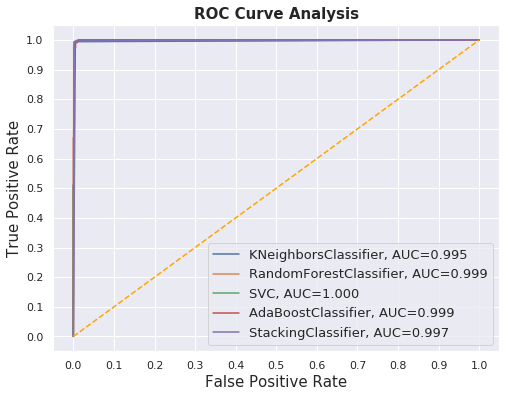

In [11]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

optimal_classifiers = [
    KNeighborsClassifier(n_neighbors=opt_params["n_neighbors"]),
    RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42),
    SVC(kernel="rbf", C=opt_params["svm_c"],gamma=opt_params["svm_gamma"], random_state=42, probability=True),
    AdaBoostClassifier(n_estimators=opt_params["ab_estimators"], random_state=42),
    StackingClassifier(classifiers=classifiers_for_stacking, meta_classifier=lr)
]

for cls in optimal_classifiers:
    model = cls.fit(optimum_x_train_two, y_train_two)
    yproba = model.predict_proba(optimum_x_validation)[::,1]
    
    fpr, tpr, _ = roc_curve(y_validation,  yproba)
    auc = roc_auc_score(y_validation, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### 10. Train the method that gives the most accurate predictions so far (i.e. the highest overall accuracy) on the original train set after applying the best feature selection and normalization strategy and compute predictions on the samples of the test set(s) for which the true labels are available. Report the same accuracy measures as in step 5.

In [14]:
clf = RandomForestClassifier(n_estimators=opt_params["rf_estimators"], random_state=42)

optimum_x_train = best_selector.fit_transform(X_train, y=y_train)
optimum_x_test = best_selector.fit_transform(X_test, y=y_test)
optimum_x_test2 = best_selector.fit_transform(X_test2, y=y_test2)

clf.fit(optimum_x_train, y_train)

preds = clf.predict(optimum_x_test)

print("Accuracy of RandomForest with optimal hyperparameters on test set: {}".format(accuracy_score(y_test, preds)))
print("F-Score of RandomForest with optimal hyperparameters on test set: {}".format(f1_score(y_test, preds)))
print("Sensitivity of RandomForest with optimal hyperparameters on test set: {}".format(recall_score(y_test, preds)))
print("Specificity of RandomForest with optimal hyperparameters on test set: {}".format(recall_score(y_test, preds,pos_label=0)))
print("Precision of RandomForest with optimal hyperparameters on test set: {}".format(precision_score(y_test, preds)))
print("ROC-Auc Score of RandomForest with optimal hyperparameters on test set: {}".format(roc_auc_score(y_test, preds)))
print("MCC of RandomForest with optimal hyperparameters on test set: {}\n\n".format(matthews_corrcoef(y_test, preds)))

preds = clf.predict(optimum_x_test2)

print("Accuracy of RandomForest with optimal hyperparameters on test set2: {}".format(accuracy_score(y_test2, preds)))
print("F-Score of RandomForest with optimal hyperparameters on test set2: {}".format(f1_score(y_test2, preds)))
print("Sensitivity of RandomForest with optimal hyperparameters on test set2: {}".format(recall_score(y_test2, preds)))
print("Specificity of RandomForest with optimal hyperparameters on test set2: {}".format(recall_score(y_test2, preds,pos_label=0)))
print("Precision of RandomForest with optimal hyperparameters on test set2: {}".format(precision_score(y_test2, preds)))
print("ROC-Auc Score of RandomForest with optimal hyperparameters on test set2: {}".format(roc_auc_score(y_test2, preds)))
print("MCC of RandomForest with optimal hyperparameters on test set2: {}\n\n".format(matthews_corrcoef(y_test2, preds)))

Accuracy of RandomForest with optimal hyperparameters on test set: 0.959099437148
F-Score of RandomForest with optimal hyperparameters on test set: 0.943610967408
Sensitivity of RandomForest with optimal hyperparameters on test set: 0.938271604938
Specificity of RandomForest with optimal hyperparameters on test set: 0.971057294743
Precision of RandomForest with optimal hyperparameters on test set: 0.94901144641
ROC-Auc Score of RandomForest with optimal hyperparameters on test set: 0.954664449841
MCC of RandomForest with optimal hyperparameters on test set: 0.911561797752


Accuracy of RandomForest with optimal hyperparameters on test set2: 0.973338802297
F-Score of RandomForest with optimal hyperparameters on test set2: 0.938995776631
Sensitivity of RandomForest with optimal hyperparameters on test set2: 0.976573938507
Specificity of RandomForest with optimal hyperparameters on test set2: 0.972478255225
Precision of RandomForest with optimal hyperparameters on test set2: 0.90420244012

### 11. Do literature review and find publications on the same topic. Which methods performed the best? Compare them with the methods you developed in this project. Can you improve your methods using the techniques implemented in the literature? Suggest ideas for improvement.

## Publications

1. Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, VÃ©ronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

2. Richardson, Ian & Thomson, Murray & Infield, David. (2008). A high-resolution domestic building occupancy model for energy demand simulations. Energy and Buildings. 40. 1560-1566. 10.1016/j.enbuild.2008.02.006. 

3. S. Meyn, A. Surana, Y. Lin, S.M. Oggianu, S. Narayanan, T.A. Frewen, A sensor-utility-network method for estimation of occupancy in buildings, in: Decision and Control, 2009 held jointly with the 2009 28th Chinese Control Conference. CDC/CCC 2009. Proceedings of the 48th IEEE Conference on, IEEE, Shanghai, P.R. China, 2009, pp. 1494–1500.

4. ] V.L. Erickson, Y. Lin, A. Kamthe, R. Brahme, A. Surana, A.E. Cerpa, M.D. Sohn, S. Narayanan, Energy efficient building environment control strategies using real-time occupancy measurements, in: Proceedings of the first ACM workshop on embedded sensing systems for energy-efficiency in buildings, ACM, Berkeley, California, 2009, pp. 19–24.

5. ] C. Liao, P. Barooah, An integrated approach to occupancy modeling and estimation in commercial buildings, in: American Control Conference (ACC), IEEE, Baltimore, MD, 2010, pp. 3130–3135.

## Methods implemented in the literature

Random Forest performed the best in the publications as well. Since this is a very well established problem, almost all methods that I have performed was already performed by other researchers. So, the results are very similiar because of that. I can definitely improve my methods using the tecniques implemented in the literature. For instance, I can use bootstrap sampling for evaluating just like in the first article. I could also optimize the parameters of linear discriminant analysis which gives a fairly good accuracy.